In [1]:
import SimpleITK as sik
from DicomRTTool.ReaderWriter import DicomReaderWriter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import  glob
from scipy.spatial import ConvexHull
from Constants import Const
import joblib
from scipy.spatial.distance import cdist, pdist, squareform

import matplotlib as mpl

In [2]:
dcm_files = glob.glob(Const.data_dir + '/DICOM/**.dcm')
dcm_files

['../data//DICOM/ima_25_uid_2.16.840.1.113662.2.2364943184436745070129103837919802504242.dcm',
 '../data//DICOM/902488_20161207T164704[HNPF]_005_RTS.dcm',
 '../data//DICOM/902488_20161207T170005[HNPF]_003_RTS.dcm',
 '../data//DICOM/902488_20161207T171405[HNPF]_001_RTS.dcm',
 '../data//DICOM/dose_uid_2.16.840.1.113669.2.931128.192763.20161117114810.147583.dcm',
 '../data//DICOM/ima_100_uid_1.2.840.113704.1.111.1072.1211221370.628.dcm',
 '../data//DICOM/ima_100_uid_1.2.840.113704.1.111.2096.1214247306.623.dcm',
 '../data//DICOM/ima_100_uid_2.16.840.1.113662.2.2364943184436745070129103837969810065985.dcm',
 '../data//DICOM/ima_101_uid_1.2.840.113704.1.111.1072.1211221370.629.dcm',
 '../data//DICOM/ima_101_uid_1.2.840.113704.1.111.2096.1214247306.624.dcm',
 '../data//DICOM/ima_101_uid_2.16.840.1.113662.2.2364943184436745070129103837969810163967.dcm',
 '../data//DICOM/ima_102_uid_1.2.840.113704.1.111.1072.1211221370.630.dcm',
 '../data//DICOM/ima_102_uid_1.2.840.113704.1.111.2096.1214247307

In [3]:
class BetterDicomReader(DicomReaderWriter):
    
    def __init__(self,ddir,**kwargs):
        kwargs['verbose'] = False
        kwargs['get_dose_output'] = True
        super(BetterDicomReader,self).__init__(**kwargs)
        self.walk_through_folders(ddir)
    
    def get_contour_mask_index(self,name):
        names = self.Contour_Names
        if name in names:
            return names.index(name) + 1
        return -1

    def set_by_uid(self,uid):
#         format_string = lambda x: str(x)
#         if isinstance(uid,int):
        format_string = lambda x: int(x)
    
        for key, pdict in self.series_instances_dictionary.items():
            if format_string(pdict.get('PatientID')) == format_string(uid):
                self.index = key
                return True
        print('failed to find patient id', uid)
        return False
    
    def get_all_uids(self):
        uids = [(k, pdict.get('PatientID',-1)) for k,pdict in self.series_instances_dictionary.items()]
        uids = sorted(uids, key = lambda x: x[0])
        return [u[1] for u in uids]
    
    def get_patient(self,uid=None,index=None):
        if uid is None and index is None:
            print('need index or uid')
            return False
        if uid is not None:
            if index is not None:
                print('using uid instead of index')
            format_string = lambda x: int(x)
            for key, pdict in self.series_instances_dictionary.items():
                if format_string(pdict.get('PatientID')) == format_string(uid):
                    return pdict
        else:
            pdict = self.series_instances_dictionary.get(index)
            return pdict
        
    def get_current_patient(self):
        return self.series_instances_dictionary[self.index]
    
def get_associations(dr):
    associations = {}
    all_rois = dr.return_rois()
    for roi in all_rois:
        if 'ctv ' in roi.lower() or roi.lower() == 'ctv':
            associations[roi] = 'CTV'
        if 'gtv ' in roi or roi.lower() == 'gtv':
            if 'node' in roi:
                associations[roi] = 'GTVn'
            else:
                associations[roi] = 'GTVp'
        if 'oar' in roi:
            associations[roi] = roi.replace('oar','').strip()
    return associations
    
def get_all_patients(dicom_dir, rois = None, associations = None):
    if rois is None:
        rois = ['tongue','rt_sternocleidomastoid_m','lt_sternocleidomastoid_m'] + ['GTVp']
    dr = BetterDicomReader(dicom_dir)
    if associations is None:
        associations = get_associations(dr)
    dr.set_contour_names_and_associations(Contour_Names=rois,associations=associations)
    
    all_uids = dr.get_all_uids()
    plist = []
    roi_map = {i+1: roi for i,roi in enumerate(rois)}
    for uid in all_uids:
        dr.set_by_uid(uid)
        dr.get_images_and_mask()
        patient = dr.get_current_patient()
        patient['ArrayDicom'] = dr.ArrayDicom[:]
        patient['mask'] = dr.mask[:]
        plist.append(patient)
    return plist, roi_map


In [27]:
def cloud_centroid(points):
    return (points.max(axis=0) + points.min(axis=0))/2
  
def convex_hull(points):
    hull = ConvexHull(points=points)
    hull_points = points[hull.vertices]
    return hull_points

def pcloud_to_convex_hull(roi_clouds):
    temp = {}
    for k,v in roi_clouds.items():
        if v.shape[0] > 3:
            hull_points = convex_hull(v)
            temp[k] = hull_points
        else:
            temp[k] = v
    return temp

def filter_pcloud_outliers(points, maxq = .95, min_k = 3):
    #removes all points that have less than min_k neighbors at within the bottom maxq % in terms of distance
    if points.shape[0] < 10:
        return points
    dists = pdist(points)
    square_dists = squareform(dists)
    (maxval) = np.quantile(dists,[maxq])
    good = (square_dists < maxval).sum(axis=1)
    good = (good >= min_k)
    return points[good]

def get_roi_pointclouds(pdict, roi_map, scale = True, convexify=False):
    #get locations of contours.  I may need to tweak this part if I want to get actual dose values?
    clouds = {}
    mask = pdict['mask']
    #get array locations
    all_points = []
    for index, roi in roi_map.items():
        #should be x, y, z if I tranpose it (default it's slicexheightxwidth)
        contour = np.argwhere(mask.T == index)
        if contour.shape[0] > 3:
            #if we want to only save the convex hull or all points
            if convexify:
                contour = convex_hull(contour)
            all_points.append(contour)
        clouds[roi] = contour
    #correct for centroid of all points and scale to distance values
    if scale:
        #I'm not actually sure this is valid test later somehow
        #but recenters the points and then uses thickness to scale x,y, and z
        #may have issues if missing some organs when comparing between patients?
        all_points = np.vstack(all_points)
        center = cloud_centroid(all_points)
        zscale = pdict['Slice_Thickness']
        xscale = pdict['Pixel_Spacing_X']
        yscale = pdict['Pixel_Spacing_Y']
        if xscale != yscale:
            print('different height/widht scales',xscale,yscale)
        for k,v in clouds.items():
            if v.shape[0] < 1:
                continue
            v = v - center
            v[0,:] = v[0,:]*xscale
            v[1,:] = v[1,:]*yscale
            v[2,:] = v[2,:]*zscale
            v = filter_pcloud_outliers(v)
            clouds[k] = v
    
    return clouds

def pointcloud_distance(pc1,pc2,metric='euclidean'):
    #this assumes they're alread convex hulls
    if pc1.shape[0] < 1 or pc2.shape[0] < 1:
        return False
    cdists = cdist(pc1,pc2,metric)
    if cdists.shape[0] < 1:
        return False
    min_dist = cdists.min()
    
    #this should check for overlap
    #somewhat simple, but looks at closests points and checks if source roi is closer
    #to target's centroid than the point on the target roi
    min_locs = np.argwhere(cdists==min_dist)
    target_center = cloud_centroid(pc2)
    
    for min_args in min_locs:
        min_pc1 = pc1[min_args[0]]
        min_pc2 = pc2[min_args[1]]
        if np.linalg.norm(min_pc1 - target_center) < np.linalg.norm(min_pc1 - target_center):
            return -min_dist
    return min_dist

def pc_dist_worker(args):
    if args[0] == args[1]:
        return 0
    clouds = args[2]
    return pointcloud_distance(clouds[args[0]],clouds[args[1]])

def get_interorgan_distances(roi_clouds, roi_map=None, convexify=True):
    if roi_map is not None:
        rois = [roi_map[k] for k in sorted(roi_map)]
    else:
        rois = list(roi_clouds.keys())
    dists = []
    #get convex hull for interorgan_distance if I remove that from the default processing
    if convexify:
        roi_clouds = pcloud_to_convex_hull(roi_clouds)
    for roi in rois:
        dlist = joblib.Parallel(n_jobs=-2)(joblib.delayed(pc_dist_worker)((roi,r2,roi_clouds)) for r2 in rois)
        dists.append(dlist)
        print(roi,'done')

    return np.array(dists), rois

def calc_spatial_info(pdict):
    #adds each roi's convex hull as a list of points and calculates inter-organ min distances
    temp = {k: v for k, v in pdict.items()}
    roi_clouds = get_roi_pointclouds(pdict, roi_map=roi_map,scale=True)
    io_dists, rois = get_interorgan_distances(roi_clouds, roi_map)
    temp['contours'] = roi_clouds
    temp['distances'] = io_dists
    return temp

def process_patient_list(plist, roi_map = None):
    new_plist = []
    for pdict in plist:
        temp = calc_spatial_info(pdict)
        new_plist.append(temp)
    return new_plist

rois = ['GTVp','GTVn','brainstem','cricoid_cartilage','cricopharnygeal_muscle','esophagus','genioglossus_m',
        'hard_palate','hyoid_bone','ipc','larynx','lower_lip','lt_ant_digastric_m','rt_ant_digastric_m',
        'lt_mastoid','rt_mastoid',
        'lt_masseter_m','rt_masseter_m',
        'mpc','ipc','spc',
        'soft_palate','upper_lip',
        'rt_sternocleidomastoid_m','lt_sternocleidomastoid_m',
       ]
plist, roi_map = get_all_patients(Const.data_dir + '/DICOM/',rois=rois)
plist = process_patient_list(plist,roi_map)
plist

Loading through DICOM files:   0%|                        | 0/1 [00:00<?, ?it/s]

Had an error loading ../data//DICOM/dose_uid_2.16.840.1.113669.2.931128.192763.20161117114810.147583.dcm
Had an error loading ../data//DICOM/plan_uid_2.16.840.1.113669.2.931128.192763.20161117114809.595057.dcm


Loading through DICOM files: 100%|████████████████| 1/1 [00:01<00:00,  1.28s/it]


Index 0, description  at ../data//DICOM/
Index 1, description  at ../data//DICOM/
Index 2, description  at ../data//DICOM/
Index 3, description None at ../data//DICOM/
4 unique series IDs were found. Default is index 0, to change use set_index(index)
The following ROIs were found
brainstem
c1_vertebra
c2_vertebra
c3_vertebra
c4_vertebra
c5_vertebra
c6_vertebra
c7_vertebra
cricoid_cartilage
cricopharyngeal_muscle
esophagus
extended_oral_cavity
genioglossus_m
glottic_area
hard_palate
hyoid_bone
ipc
larynx
lower_lip
lt_ant_digastric_m
lt_anterior_scalene_m
lt_anterior_seg_eyeball
lt_brachial_plexus
lt_buccinator_m
lt_clavicle
lt_internal_carotid_a
lt_internal_jugular_v
lt_lateral_pterygoid_m
lt_levator_scapulae_m
lt_masseter_m
lt_mastoid
lt_medial_pterygoid_m
lt_parotid_gland
lt_post_digastric_m
lt_posterior_scalenes_m
lt_posterior_seg_eyeball
lt_sternocleidomastoid_m
lt_submandibular_gland
lt_thyroid_lobe
lt_trapezius_m
mandible
manubrium
mpc
mylogeniohyoid_m
pituitary_gland
rt_ant_digas

[{'PatientID': '001',
  'SeriesInstanceUID': '1.2.840.113704.1.111.2624.1214247243.15',
  'StudyInstanceUID': '1.2.840.113704.1.111.3580.1214237738.8',
  'RTs': {'2.16.840.1.114337.328603361.130460.1481152445.405': {'Path': '../data//DICOM/902488_20161207T171405[HNPF]_001_RTS.dcm',
    'ROI_Names': ['brainstem',
     'c1_vertebra',
     'c2_vertebra',
     'c3_vertebra',
     'c4_vertebra',
     'c5_vertebra',
     'c6_vertebra',
     'c7_vertebra',
     'cricoid_cartilage',
     'cricopharyngeal_muscle',
     'esophagus',
     'extended_oral_cavity',
     'genioglossus_m',
     'glottic_area',
     'hard_palate',
     'hyoid_bone',
     'ipc',
     'larynx',
     'lower_lip',
     'lt_ant_digastric_m',
     'lt_anterior_scalene_m',
     'lt_anterior_seg_eyeball',
     'lt_brachial_plexus',
     'lt_buccinator_m',
     'lt_clavicle',
     'lt_internal_carotid_a',
     'lt_internal_jugular_v',
     'lt_lateral_pterygoid_m',
     'lt_levator_scapulae_m',
     'lt_masseter_m',
     'lt_ma

In [28]:
plist[0]['contours'].keys()

dict_keys(['GTVp', 'GTVn', 'brainstem', 'cricoid_cartilage', 'cricopharnygeal_muscle', 'esophagus', 'genioglossus_m', 'hard_palate', 'hyoid_bone', 'ipc', 'larynx', 'lower_lip', 'lt_ant_digastric_m', 'rt_ant_digastric_m', 'lt_mastoid', 'rt_mastoid', 'lt_masseter_m', 'rt_masseter_m', 'mpc', 'spc', 'soft_palate', 'upper_lip', 'rt_sternocleidomastoid_m', 'lt_sternocleidomastoid_m'])

<Axes3DSubplot:>

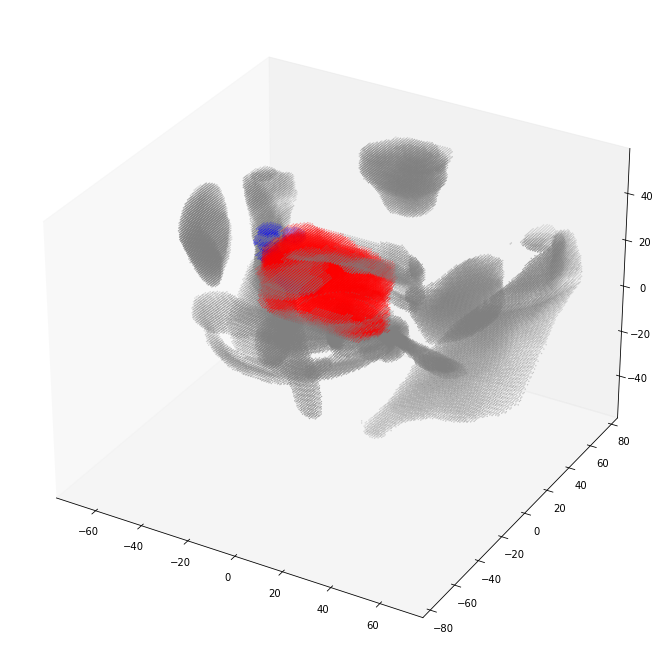

In [48]:
def plot_pclouds(pdict,figsize=(20,12),convexify=True):
    fig = plt.figure(figsize=figsize,facecolor='w')
    ax = fig.add_subplot(projection='3d')
    ax.set_facecolor('w')
    ax.grid(False)
    colors = mpl.colormaps['tab20']
    contours = pdict['contours']
    for i,(roi,pointcloud) in enumerate(contours.items()):
        if pointcloud.shape[0] < 4:
            continue
        size = .1
        if convexify:
            pointcloud = convex_hull(pointcloud)
            size = 10
#         color=colors(i)
        color = 'red' if 'gtvp' in roi.lower() else ('blue' if 'gtvn' in roi.lower() else 'grey')
        ax.scatter(pointcloud[:,0],pointcloud[:,1],pointcloud[:,2],s=size,color=color)
    return ax

# filter_pcloud_outliers(plist[-1]['contours']['spc']).shape
plot_pclouds(plist[-1],convexify=False)

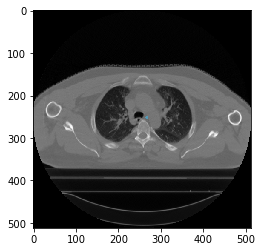

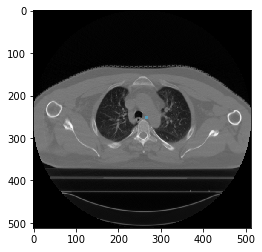

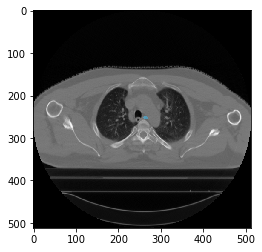

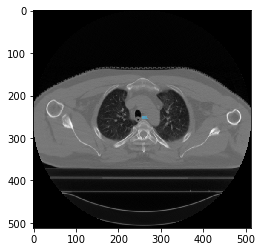

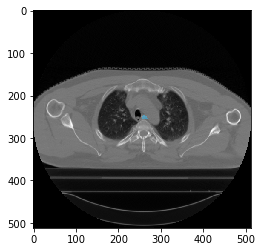

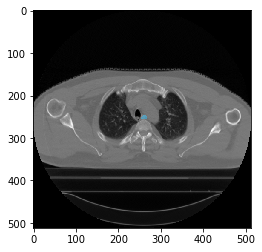

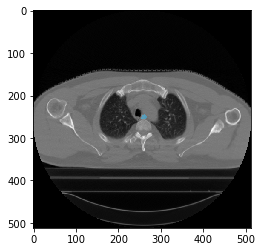

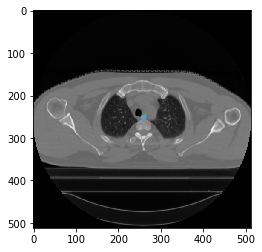

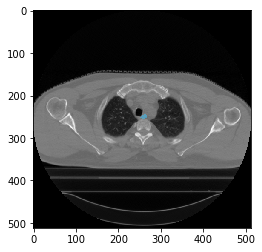

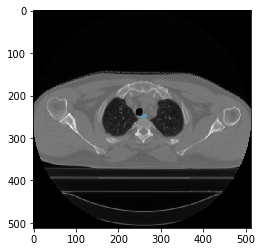

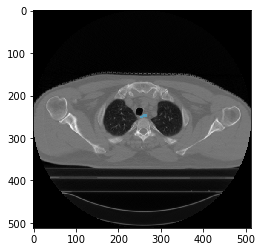

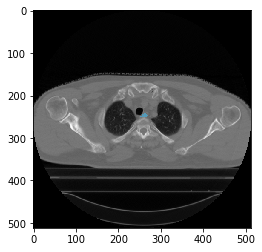

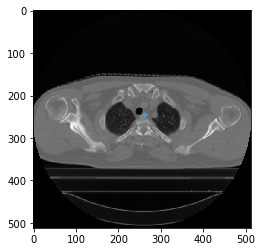

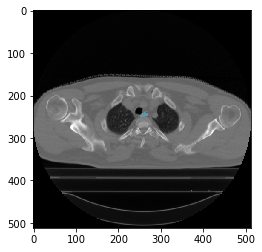

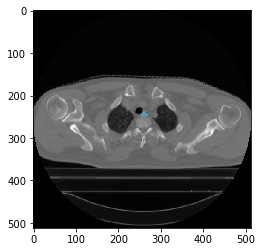

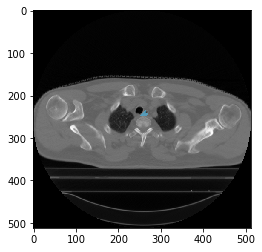

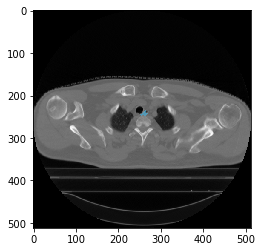

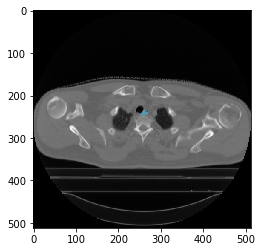

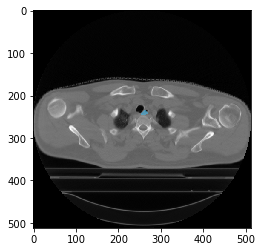

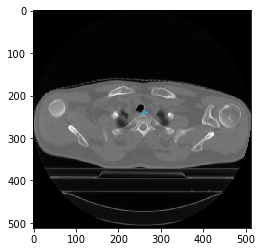

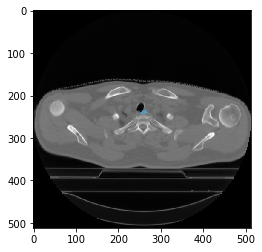

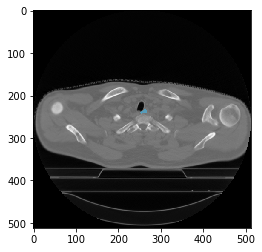

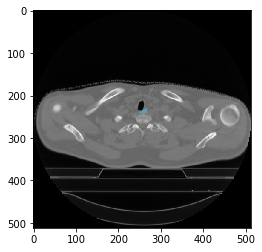

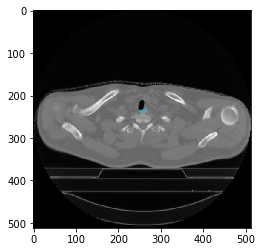

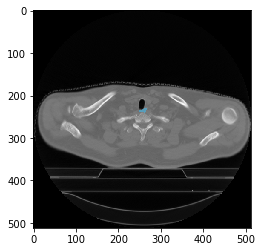

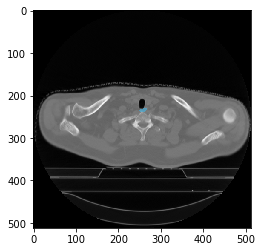

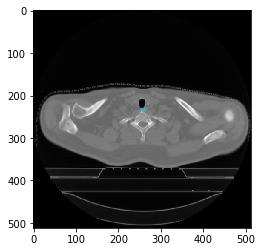

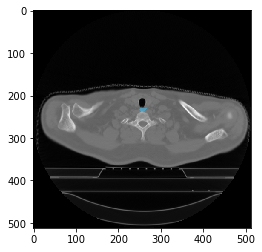

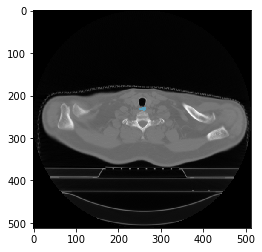

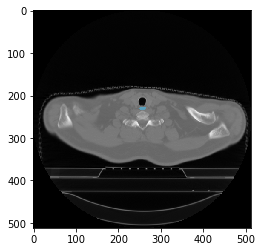

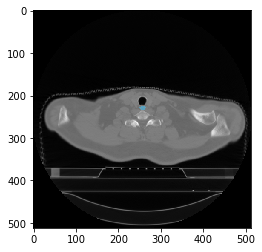

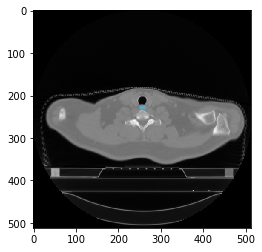

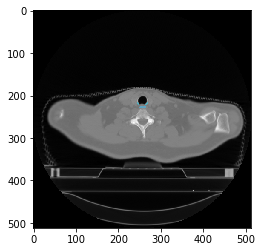

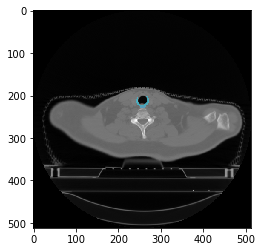

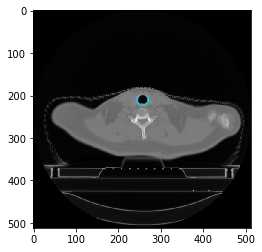

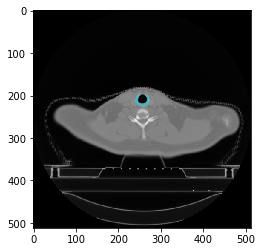

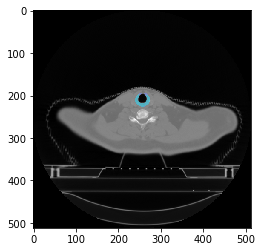

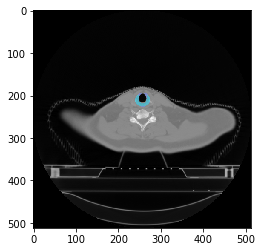

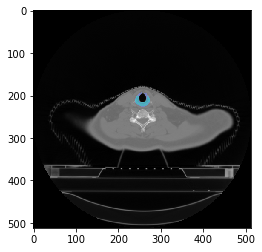

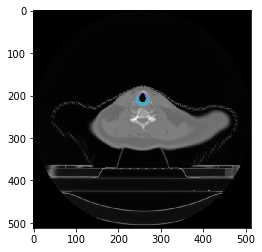

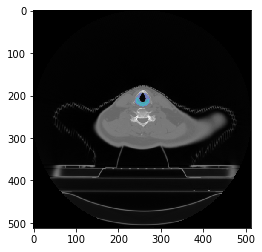

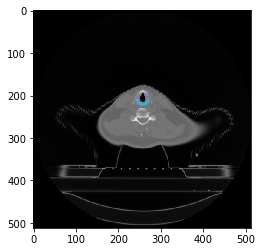

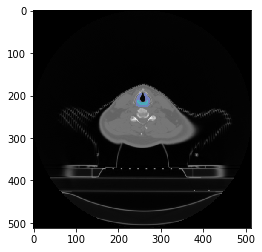

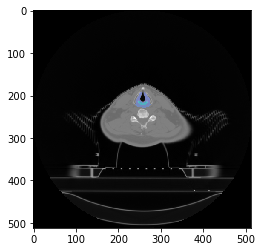

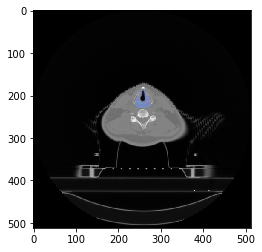

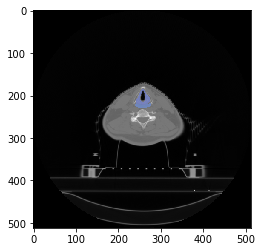

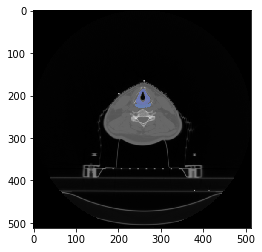

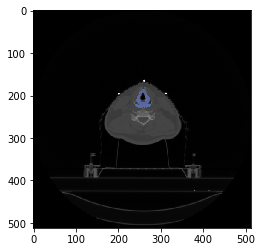

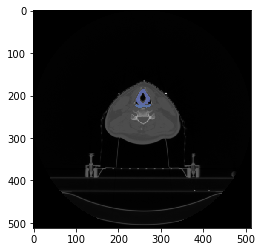

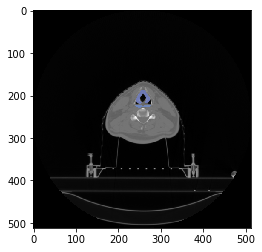

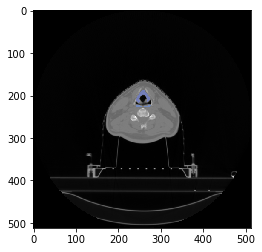

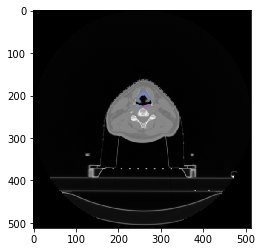

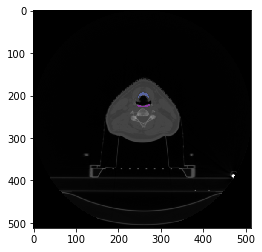

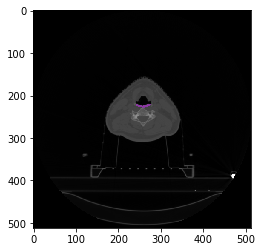

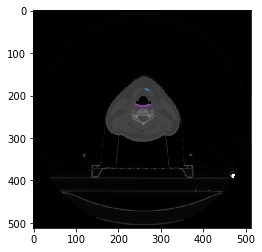

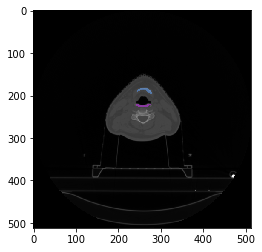

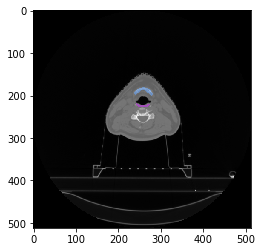

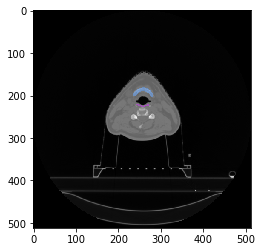

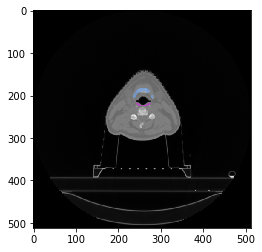

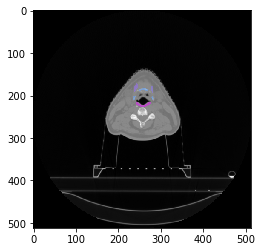

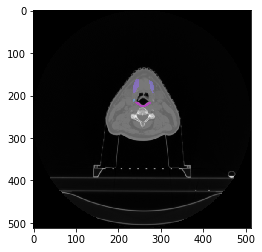

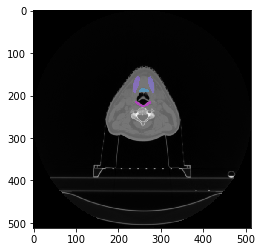

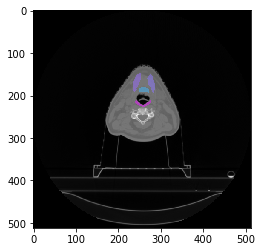

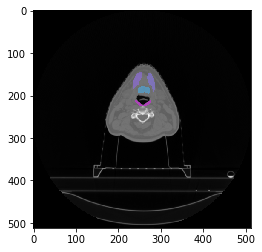

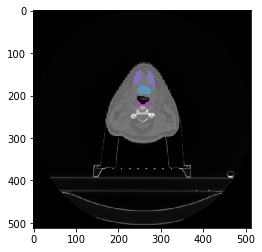

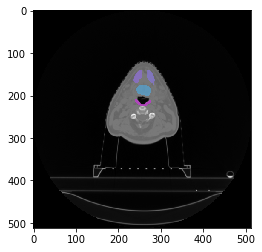

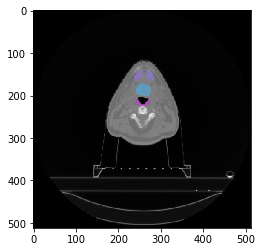

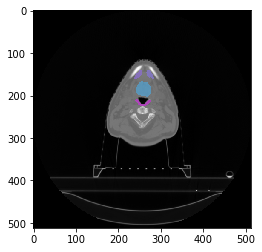

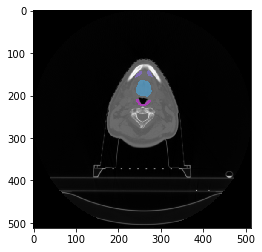

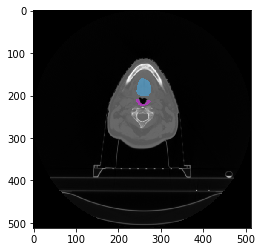

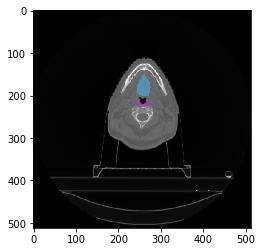

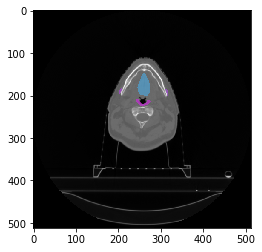

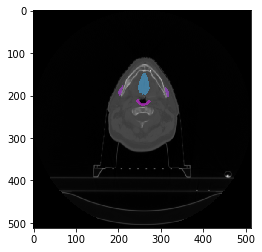

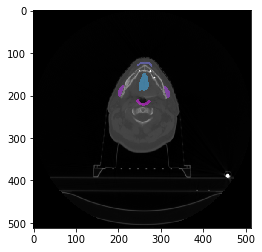

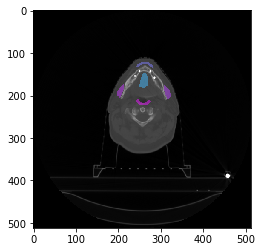

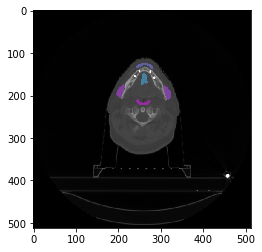

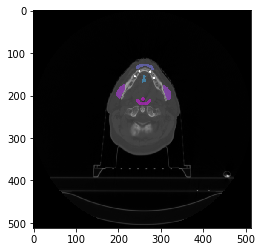

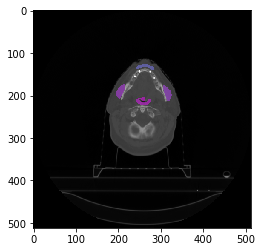

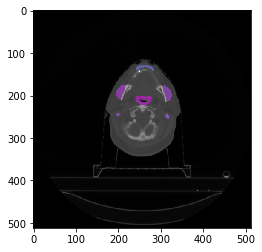

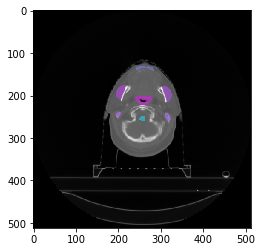

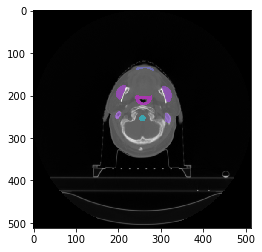

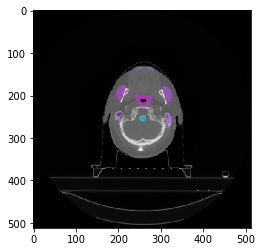

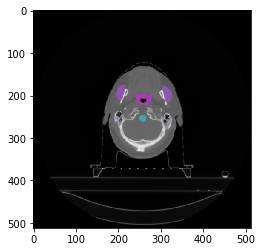

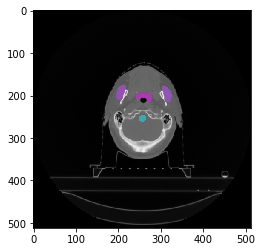

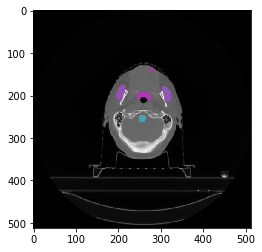

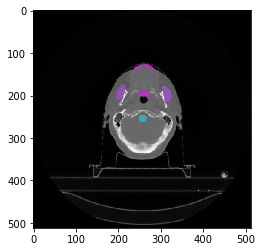

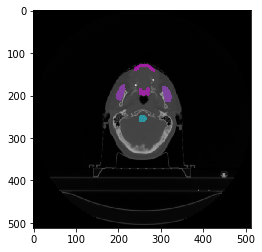

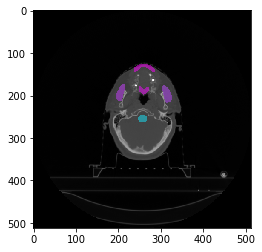

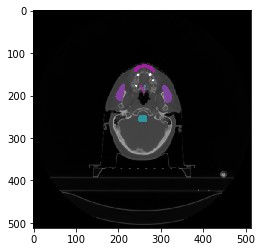

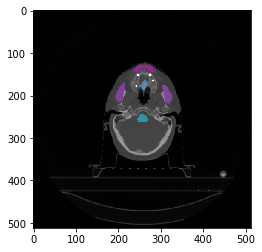

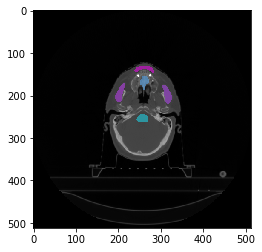

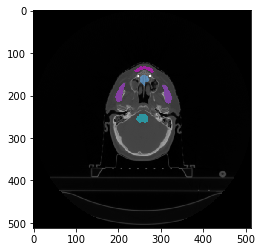

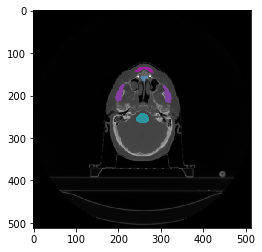

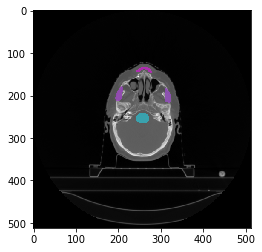

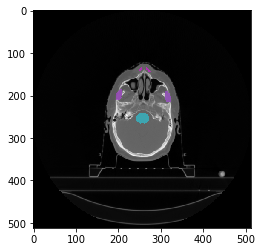

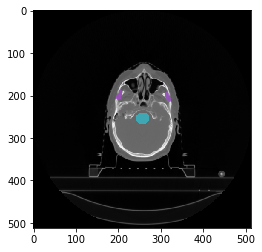

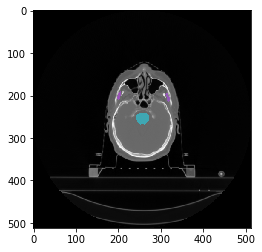

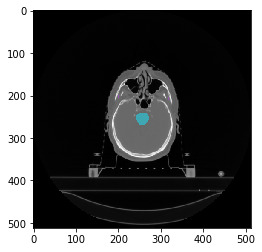

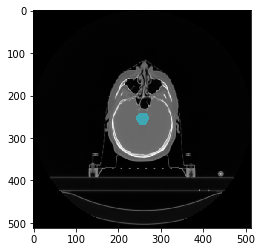

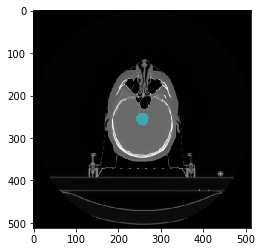

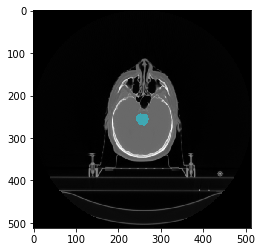

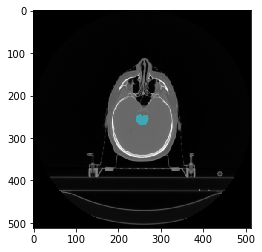

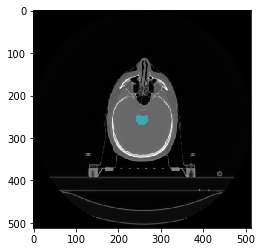

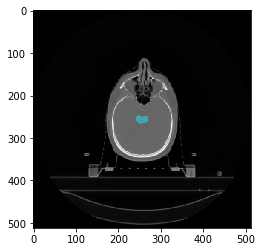

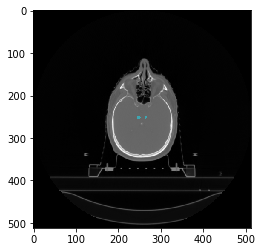

In [7]:
def display_slices(pdict, skip=1):
    """
    Displays a series of slices in z-direction that contains the segmented regions of interest.
    Ensures all contours are displayed in consistent and different colors.
        Parameters:
            image (array-like): Numpy array of image.
            mask (array-like): Numpy array of mask.
            skip (int): Only print every nth slice, i.e. if 3 only print every 3rd slice, default 1.
        Returns:
            None (series of in-line plots).
    """
    image = pdict['ArrayDicom']
    mask = pdict['mask']
    slice_locations = np.unique(np.where(mask != 0)[0]) # get indexes for where there is a contour present 
    slice_start = slice_locations[0] # first slice of contour 
    slice_end = slice_locations[len(slice_locations)-1] # last slice of contour
    
    counter = 1
    
    for img_arr, contour_arr in zip(image[slice_start:slice_end+1], mask[slice_start:slice_end+1]): # plot the slices with contours overlayed ontop
        if counter % skip == 0: # if current slice is divisible by desired skip amount 
            masked_contour_arr = np.ma.masked_where(contour_arr == 0, contour_arr)
            plt.imshow(img_arr, cmap='gray', interpolation='none')
            plt.imshow(masked_contour_arr, cmap='cool', interpolation='none', alpha=0.5, vmin = 1, vmax = np.amax(mask)) # vmax is set as total number of contours so same colors can be displayed for each slice
            plt.show()
        counter += 1
        
display_slices(plist[0])